## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Set visualization styles
plt.style.use("fivethirtyeight")
sns.set_theme(style="whitegrid")

# Ignore warnings for clean output
warnings.simplefilter("ignore")

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load the dataset
file_path = "dataset.xlsx"  # Ensure the file is in the same directory as the notebook
df = pd.read_excel(file_path)

# Display basic info
print("Dataset Loaded Successfully!\n")
print(df.info())
print("\nFirst 5 Rows of Data:\n", df.head())


Dataset Loaded Successfully!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  1826 non-null   int64         
 1   date        1826 non-null   datetime64[ns]
 2   sales       1826 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 42.9 KB
None

First 5 Rows of Data:
    Unnamed: 0       date  sales
0           0 2013-01-01     13
1           1 2013-01-02     11
2           2 2013-01-03     14
3           3 2013-01-04     13
4           4 2013-01-05     10


## Clean and prepare Data

In [3]:
# Drop unnecessary columns (if present)
df.drop(columns=["Unnamed: 0"], inplace=True, errors="ignore")

# Check for missing values
missing_values = df.isnull().sum()

print("Missing Values:\n", missing_values)


Missing Values:
 date     0
sales    0
dtype: int64


## Visualize Sales Trends

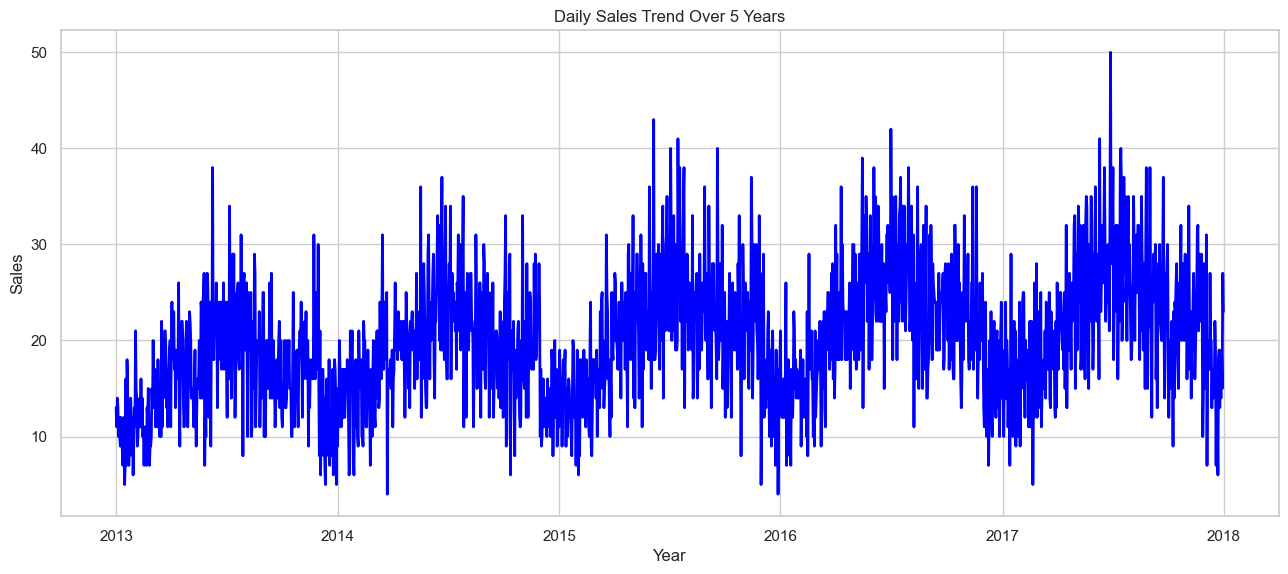

In [4]:
# Convert date column to datetime format (if not already)
df["date"] = pd.to_datetime(df["date"])

# Plot sales over time
plt.figure(figsize=(14, 6))
plt.plot(df["date"], df["sales"], color="blue", linewidth=2)
plt.xlabel("Year")
plt.ylabel("Sales")
plt.title("Daily Sales Trend Over 5 Years")
plt.grid(True)
plt.show()


## EDA 

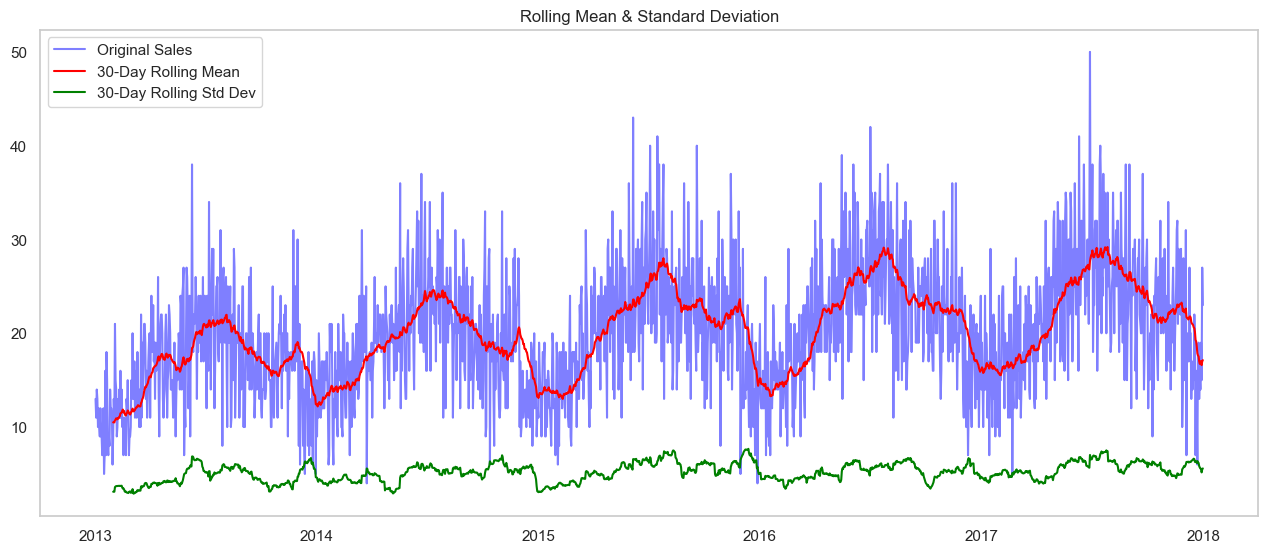

In [6]:
# Compute rolling mean and standard deviation
df["rolling_mean"] = df["sales"].rolling(window=30).mean()  # 30-day window
df["rolling_std"] = df["sales"].rolling(window=30).std()

# Plot rolling statistics
plt.figure(figsize=(14,6))
plt.plot(df["date"], df["sales"], label="Original Sales", color="blue", alpha=0.5)
plt.plot(df["date"], df["rolling_mean"], label="30-Day Rolling Mean", color="red")
plt.plot(df["date"], df["rolling_std"], label="30-Day Rolling Std Dev", color="green")
plt.legend()
plt.title("Rolling Mean & Standard Deviation")
plt.grid()
plt.show()


## Decompose the Time Series

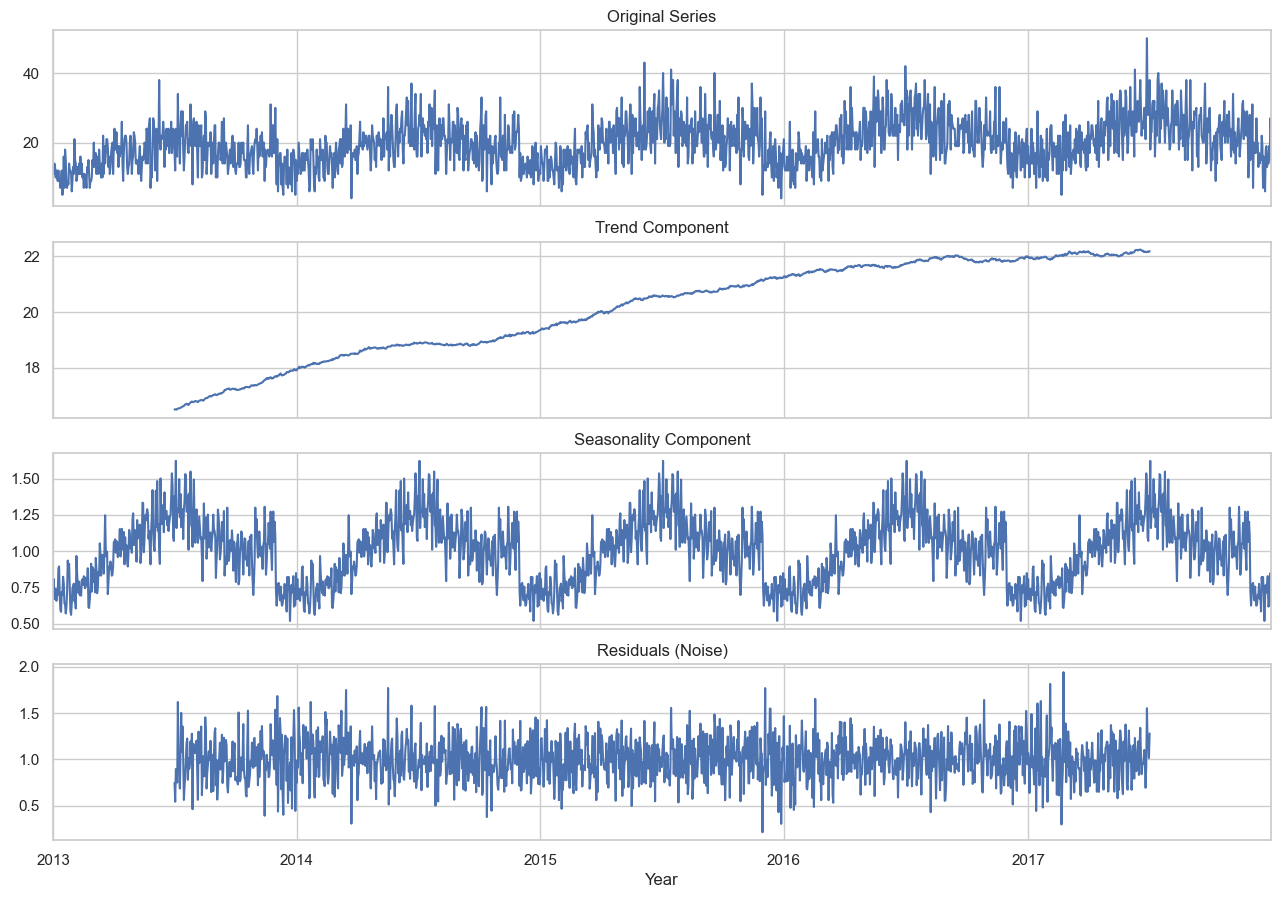

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series (multiplicative model)
decomposition = seasonal_decompose(df.set_index("date")["sales"], model="multiplicative", period=365)

# Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(14,10), sharex=True)
decomposition.observed.plot(ax=axes[0], title="Original Series")
decomposition.trend.plot(ax=axes[1], title="Trend Component")
decomposition.seasonal.plot(ax=axes[2], title="Seasonality Component")
decomposition.resid.plot(ax=axes[3], title="Residuals (Noise)")
plt.xlabel("Year")
plt.show()


## Autocorrelation & Partial Autocorrelation Plots

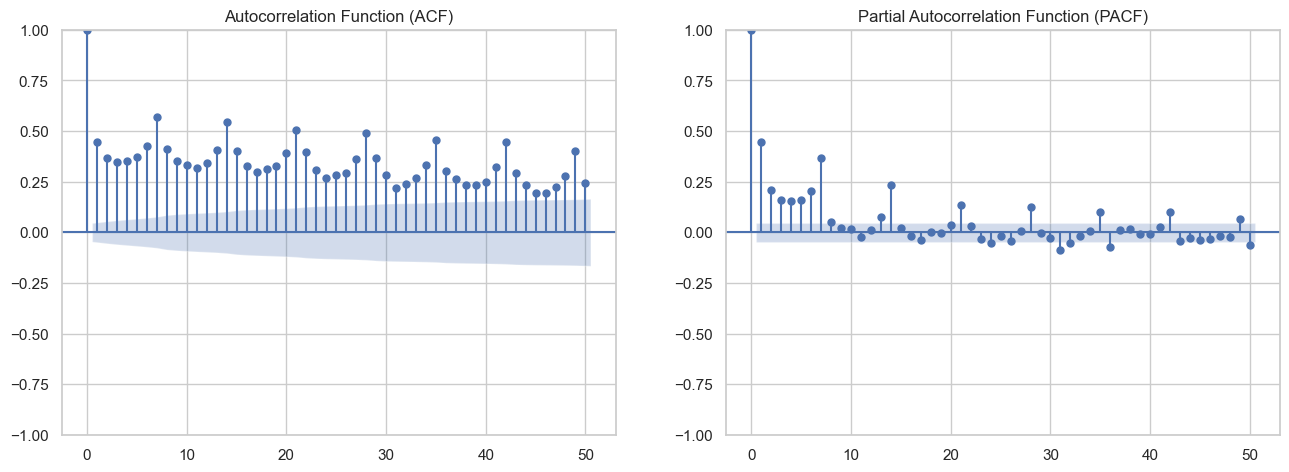

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# ACF Plot
plot_acf(df["sales"], lags=50, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF Plot
plot_pacf(df["sales"], lags=50, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()


## Check for Stationarity

In [9]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(df["sales"])

# Print test results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

# Check stationarity condition
if result[1] < 0.05:
    print("✅ Data is stationary (p-value < 0.05)")
else:
    print("❌ Data is non-stationary (p-value > 0.05) — Differencing required")


ADF Statistic: -3.157670556332791
p-value: 0.022569380626572377
Critical Values:
   1%: -3.4339840952648695
   5%: -2.8631452508003057
   10%: -2.567624583142913
✅ Data is stationary (p-value < 0.05)


In [10]:
df["sales_diff"] = df["sales"].diff().dropna()

# Re-run ADF test
result_diff = adfuller(df["sales_diff"].dropna())

print("ADF Statistic (After Differencing):", result_diff[0])
print("p-value:", result_diff[1])


ADF Statistic (After Differencing): -12.676793886047397
p-value: 1.2109276320441247e-23


## Implementing ARIMA Model

In [11]:

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

warnings.filterwarnings("ignore")

# Set plot style
sns.set_style("whitegrid")


In [12]:
# Fit Auto-ARIMA to find the best parameters
auto_arima_model = pm.auto_arima(df['sales'], seasonal=False, trace=True, suppress_warnings=True)

# Print best (p, d, q) parameters
print("Optimal ARIMA parameters:", auto_arima_model.order)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11340.087, Time=1.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12329.035, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11965.113, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11347.169, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12327.036, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11339.205, Time=1.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11339.382, Time=0.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11340.636, Time=0.67 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11313.673, Time=1.92 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=11334.917, Time=0.75 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11109.620, Time=3.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=11122.742, Time=3.14 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=11146.193, Time=4.37 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=11307.886, Time=1.15 sec
 ARIMA(3,1,2)(0,0,0

In [13]:
# Extract best (p, d, q) values from Auto-ARIMA
p, d, q = auto_arima_model.order

# Fit ARIMA model
arima_model = ARIMA(df['sales'], order=(p, d, q))
arima_result = arima_model.fit()

# Print model summary
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -5486.361
Date:                Tue, 25 Mar 2025   AIC                          10994.723
Time:                        00:13:02   BIC                          11055.326
Sample:                             0   HQIC                         11017.078
                               - 1826                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7895      0.042     18.860      0.000       0.707       0.872
ar.L2         -1.3930      0.041    -33.568      0.000      -1.474      -1.312
ar.L3          0.7219      0.055     13.093      0.0

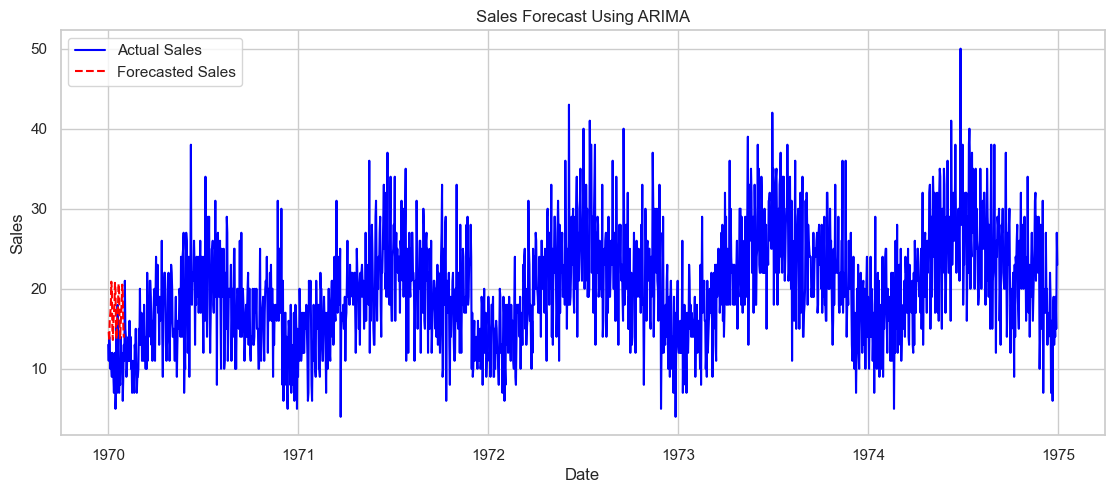

In [14]:
# Forecast next 30 days
forecast_steps = 30
forecast = arima_result.forecast(steps=forecast_steps)

# Create future date index
future_dates = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='D')[1:]

# Convert forecast to DataFrame
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast': forecast.values})
forecast_df.set_index('Date', inplace=True)

# Plot predictions
plt.figure(figsize=(12,5))
plt.plot(df.index, df['sales'], label='Actual Sales', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted Sales', color='red', linestyle="dashed")
plt.title("Sales Forecast Using ARIMA")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Split the dataset (e.g., last 30 days for testing)
train = df['sales'][:-30]
test = df['sales'][-30:]

# Fit ARIMA on training data
model_eval = ARIMA(train, order=(2, 1, 2))  # use your actual (p,d,q)
model_eval_fit = model_eval.fit()

# Forecast on the test set
forecast_eval = model_eval_fit.forecast(steps=30)

# Evaluation Metrics
mae = mean_absolute_error(test, forecast_eval)
mse = mean_squared_error(test, forecast_eval)
rmse = np.sqrt(mse)

print("Model Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error): {mae:.2f}")
print(f"MSE  (Mean Squared Error): {mse:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")


Model Evaluation Metrics:
MAE  (Mean Absolute Error): 6.18
MSE  (Mean Squared Error): 53.78
RMSE (Root Mean Squared Error): 7.33


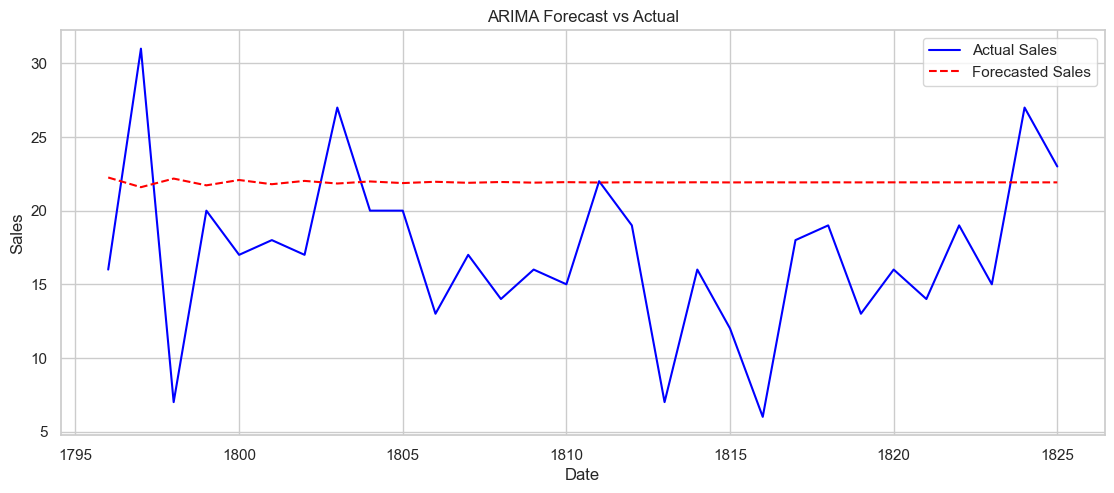

In [16]:
# Plot Actual vs Forecast
plt.figure(figsize=(12, 5))
plt.plot(test.index, test.values, label="Actual Sales", color="blue")
plt.plot(test.index, forecast_eval, label="Forecasted Sales", color="red", linestyle="--")
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11340.087, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12329.035, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11965.113, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11347.169, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12327.036, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11339.205, Time=1.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11339.382, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11340.636, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11313.673, Time=1.27 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=11334.917, Time=0.50 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11109.620, Time=3.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=11122.742, Time=3.01 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=11146.193, Time=3.96 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=11307.886, Time=1.95 sec
 ARIMA(3,1,2)(0,0,0

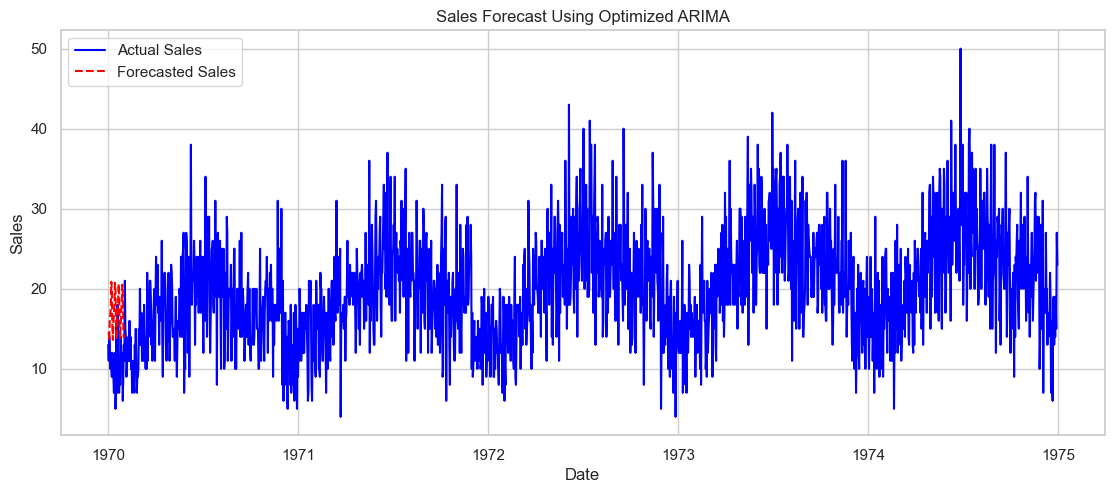

In [17]:
from pmdarima import auto_arima

# Find the best ARIMA parameters
best_arima = auto_arima(df['sales'], seasonal=False, trace=True, stepwise=True)

# Get the best order
best_arima_order = best_arima.order
print("Best ARIMA Order:", best_arima_order)

# Fit ARIMA with the best parameters
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df['sales'], order=best_arima_order)
arima_result = arima_model.fit()

# Forecast next 30 days
forecast_steps = 30
forecast = arima_result.forecast(steps=forecast_steps)

# Create future date index
future_dates = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='D')[1:]

# Convert forecast to DataFrame
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast': forecast.values})
forecast_df.set_index('Date', inplace=True)

# Plot results
plt.figure(figsize=(12,5))
plt.plot(df.index, df['sales'], label='Actual Sales', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted Sales', color='red', linestyle="dashed")
plt.title("Sales Forecast Using Optimized ARIMA")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Get actual vs predicted values for the test set
actual = df['sales'].iloc[-forecast_steps:]  # Last 30 days of actual sales
predicted = forecast[:forecast_steps]        # Forecasted values

# Calculate error metrics
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)

print(f"📊 Model Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error): {mae:.2f}")
print(f"MSE  (Mean Squared Error): {mse:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")


📊 Model Evaluation Metrics:
MAE  (Mean Absolute Error): 5.47
MSE  (Mean Squared Error): 47.97
RMSE (Root Mean Squared Error): 6.93


In [20]:
import joblib
joblib.dump(arima_model,"Best_Arima_model.pkl")

['Best_Arima_model.pkl']